# Chapter 08 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import matplotlib.pyplot as plt
import mlba
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [3]:
delays_df = mlba.load_data('FlightDelays.csv')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'
delays_df[outcome] = delays_df[outcome].astype('category')

# split into training and holdout
train_X, holdout_X, train_y, holdout_y = train_test_split(
    delays_df[predictors], delays_df[outcome],
    test_size=0.40, random_state=1)

preprocess = ColumnTransformer([
    # create hourly bins departure time
    ('to_hours', FunctionTransformer(lambda x: round(x / 100).astype('int')),
                 ['CRS_DEP_TIME']),
    # keep all other features as they are
    ('unchanged', 'passthrough', ['DAY_WEEK', 'ORIGIN', 'DEST', 'CARRIER']),
])

delays_nb = Pipeline([
    ('preprocess', preprocess),
    # one-hot encode the features
    ('encoder', OneHotEncoder()),
    ('nb', MultinomialNB(alpha=0.01)),
])
delays_nb.fit(train_X, train_y)

# predict probabilities
predProb_train = delays_nb.predict_proba(train_X)
predProb_holdout = delays_nb.predict_proba(holdout_X)

# predict class membership
holdout_y_pred = delays_nb.predict(holdout_X)
train_y_pred = delays_nb.predict(train_X)

 
  The pipeline may look overly complex, but it is fairly straightforward when you think through the 
  individual steps. The full model definition is shown when printing the pipeline object.

In [4]:
delays_nb

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('to_hours',
                                                  FunctionTransformer(func=<function <lambda> at 0x17c3fab60>),
                                                  ['CRS_DEP_TIME']),
                                                 ('unchanged', 'passthrough',
                                                  ['DAY_WEEK', 'ORIGIN', 'DEST',
                                                   'CARRIER'])])),
                ('encoder', OneHotEncoder()),
                ('nb', MultinomialNB(alpha=0.01))])

 
  The `preprocess` step transforms the `CRS_DEP_TIME` variable into hourly bins. We 
  define the transformation using a lambda function `lambda x round(x / 100).astype('int')`. This
  is just a shorthand to make the code more concise. If we expect to use such a transformation more 
  often, we could have also defined a custom transformer class as follows. By inheriting from `TransformerMixin`, we get the `fit_transform` function without having to implement it.

In [5]:
from sklearn.base import TransformerMixin

class RoundToHourTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return round(X / 100).astype('int')

RoundToHourTransformer().transform(delays_df['CRS_DEP_TIME'])

0       15
1       16
2       12
3       17
4       10
        ..
2196     6
2197    17
2198    16
2199    14
2200    17
Name: CRS_DEP_TIME, Length: 2201, dtype: int64

 
  Following the preprocess step all features are categorical and we use the `OneHotEncoder` to
  convert them into a binary format in the `encoder` step. After this, we have the data in the 
  format we need for the `MultinomialNB` model (step `nb`). 

In [6]:
# split the original data frame into a train and test using the same random_state
train_df, holdout_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('display.precision', 4)
# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]].copy()
    if predictor == 'CRS_DEP_TIME':
        df[predictor] = RoundToHourTransformer().transform(df[predictor])
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len,
                               observed=False)

    # divide each value by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('display.precision')

Flight Status
ontime     0.8023
delayed    0.1977
Name: count, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME       6       7       8       9       10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

In [7]:
# classify a specific flight by searching searching among the NB predictions
# for a flight with the same predictor values
df = pd.concat([pd.DataFrame({'actual': holdout_y, 'predicted': holdout_y_pred}),
                pd.DataFrame(predProb_holdout, index=holdout_y.index)], axis=1)
mask = ((holdout_X.CARRIER == 'DL') & (holdout_X.DAY_WEEK == 7) &
        (1000 <= holdout_X.CRS_DEP_TIME) & (holdout_X.CRS_DEP_TIME < 1100) &
        (holdout_X.DEST == 'LGA') & (holdout_X.ORIGIN == 'DCA'))
df[mask]

,actual,predicted,0,1
1225,ontime,ontime,0.057989,0.942011


In [8]:
# training
mlba.classificationSummary(y_true=train_y, y_pred=train_y_pred) #, class_names=classes)

# holdout
mlba.classificationSummary(y_true=holdout_y, y_pred=holdout_y_pred) #, class_names=classes)

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998
Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


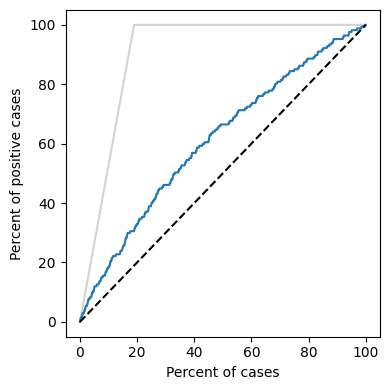

In [9]:
df = pd.DataFrame({'actual': 1 - holdout_y.cat.codes, 'prob': predProb_holdout[:, 0]})

fig, ax = plt.subplots(figsize=[4, 4])
mlba.gainsChart(df, ranking='prob', actual='actual', ax=ax, title=None)
plt.tight_layout()
plt.show()